Portfolio Position Risk Calculator and Exit Model

Import Packages

In [133]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import scipy as scp
import yfinance as yfin
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

Import Portfolio Level Data

In [134]:
port = pd.read_excel('Port.xlsx', parse_dates =[15])
port = port.rename(columns=port.loc[8])
port = port.drop(np.arange(0,12)).reset_index(drop=True)
port = port[port['Position'].notna()].reset_index(drop=True)
pd.options.display.float_format = '{:,.2f}'.format
port_val = 200000         #Value of entire portfolio including cash
cols = []
count = 1
for column in port.columns:
    if column == 'Price':
        cols.append(f'Price_{count}')
        count+=1
        continue
    cols.append(column)
port.columns = cols
port = port.sort_values('ID').reset_index(drop = True)
port
#note that Price_1 is the current price as of the Bloomberg pull, and Price_2 is the Price we bought at

,Security,PK,ID,Position,Price_1,PCS,FX Rate,Principal,Accrued,Market Val,Price_2,FX Rate,Principal,Accrued,Cost Val,Cost Date
0,AMRC US,AMRC US Equity,AMRC,140,55.10,EXCH,1,7714,NaN,7714,55,1,7700,NaN,7700,12/22/22
1,DAR US,DAR US Equity,DAR,175,66.85,EXCH,1,"11,698.75",NaN,"11,698.75",67.31,1,"11,779.57",NaN,"11,779.57",11/29/22
2,ETR US,ETR US Equity,ETR,140,105.76,EXCH,1,"14,803.60",NaN,"14,803.60",103.93,1,"14,550.20",NaN,"14,550.20",02/13/23
3,GPP US,GPP US Equity,GPP,1200,13.05,EXCH,1,15660,NaN,15660,12.27,1,"14,726.86",NaN,"14,726.86",11/23/22
4,ICLN US,ICLN US Equity,ICLN,870,19.87,EXCH,1,"17,286.90",NaN,"17,286.90",17.84,1,"15,520.45",NaN,"15,520.45",10/13/22
5,MVST US,MVST US Equity,MVST,1000,1.53,EXCH,1,1530,NaN,1530,1.96,1,"1,957.70",NaN,"1,957.70",12/09/22
6,STEM US,STEM US Equity,STEM,350,9.15,EXCH,1,"3,202.50",NaN,"3,202.50",10.55,1,"3,690.75",NaN,"3,690.75",12/09/22


Import Current Market Data

In [135]:
port_assets = list(port['ID'])
today = datetime.today().strftime('%Y-%m-%d')
start_date = "2023-01-17"
start_date = datetime.strptime(start_date,'%Y-%m-%d')
tradingdays = 252
yfin.pdr_override()
df = pdr.get_data_yahoo(port_assets, start = start_date, end = today)
df = df['Adj Close'].dropna()
port['Cost Date']=pd.to_datetime(port['Cost Date'])



port['Time Delta'] = ((datetime.today() - port['Cost Date'])/np.timedelta64(1, 'M'))
#port['Time Delta'] = temp
df

[*********************100%***********************]  7 of 7 completed


,AMRC,DAR,ETR,GPP,ICLN,MVST,STEM
Date,,,,,,,
2023-01-17,60.90,66.70,105.83,12.77,21.36,1.72,10.37
2023-01-18,61.20,64.61,106.50,12.80,21.11,1.73,10.28
2023-01-19,59.52,64.61,105.92,12.82,20.40,1.63,9.89
2023-01-20,61.75,65.63,106.35,12.86,20.60,1.65,10.22
2023-01-23,64.26,66.23,105.67,13.15,20.97,1.69,10.75
2023-01-24,64.14,64.59,106.18,13.03,20.81,1.66,9.94
2023-01-25,63.07,66.04,106.41,13.12,20.64,1.65,9.80
2023-01-26,62.92,66.90,107.37,13.22,20.63,1.60,9.57
2023-01-27,64.58,65.36,107.61,13.20,20.53,1.56,9.86


Compounded Returns for Assets Held

In [136]:
returns = (df.iloc[-1].transpose().reset_index(drop = True) / port['Price_2']).apply(lambda x: np.log(x))
returns = returns / port['Time Delta'].values
returns.index = port['ID']
returns = returns.rename('Compound Monthly Returns')
returns

ID
AMRC   -0.03
DAR    -0.00
ETR     0.10
GPP     0.01
ICLN    0.02
MVST   -0.14
STEM   -0.10
Name: Compound Monthly Returns, dtype: float64

VALUE AT RISK CALCULATIONS

1. Historical Data

In [137]:
risk_start = '2000-01-01'
hist_risk_ret = pdr.get_data_yahoo(port_assets, start = risk_start, end = today)
hist_risk_ret = hist_risk_ret.resample('M').last()
hist_risk_ret = hist_risk_ret['Adj Close']
hist_risk_ret = (hist_risk_ret.shift(1)/hist_risk_ret).apply(lambda x: np.log(x))
hist_risk_ret

[*********************100%***********************]  7 of 7 completed


,AMRC,DAR,ETR,GPP,ICLN,MVST,STEM
Date,,,,,,,
2000-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-29,NaN,0.04,0.20,NaN,NaN,NaN,NaN
2000-03-31,NaN,0.07,0.00,NaN,NaN,NaN,NaN
2000-04-30,NaN,0.17,-0.23,NaN,NaN,NaN,NaN
2000-05-31,NaN,0.20,-0.15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2022-10-31,0.09,-0.17,-0.06,-0.10,0.01,-0.30,-0.02
2022-11-30,-0.08,0.09,-0.09,0.05,-0.11,0.11,0.04
2022-12-31,0.14,0.14,0.03,-0.04,0.06,0.36,0.38


In [144]:
#comment out the plot = True if you don't want to see plots
plot = False
#plot = True
var_ret = []
var_amt = []
colnames = list(hist_risk_ret.columns)
var_pct = 5     #control variable for VAR %. Normally 5 %
icol = 0
for i in hist_risk_ret.columns:
    loss95_ret = np.percentile(hist_risk_ret[i].dropna(), var_pct)
    var_ret.append(loss95_ret)
    var_amt.append(loss95_ret*port.loc[icol,'Position']*df.iloc[-1].loc[i])
    #print(colnames[icol],'95% VAR Returns',loss95)
    if plot == True:
        plt.hist(hist_risk_ret[i]*100,bins=30,label = i)
        plt.xlabel("% Returns")
        plt.ylabel("Count")
        plt.axvline(loss95_ret*100, color='r', linestyle = 'dashed', linewidth = 2, label= f'{100-var_pct}% VAR')
        plt.legend()
        plt.show()
    icol = icol + 1

for i in range(len(var_amt)):
    print(colnames[i], f'{100-var_pct}% VAR',float("{:.2f}".format(var_ret[i]*100)) ,'%','| AMT:',float("{:.2f}".format(var_amt[i])),'$')

total_current_var_amt = sum(var_amt)

current_pos = []
ipos = 0
for i in hist_risk_ret.columns:
    current_pos.append(port.loc[ipos,'Position']*df.iloc[-1].loc[i])
    ipos = ipos + 1

print('======================================')
print(f'Total {100-var_pct}% VAR Amount:',float("{:.2f}".format(total_current_var_amt)),'$')
print(f'Total {100-var_pct}% VAR',float("{:.2f}".format(total_current_var_amt/sum(current_pos)*100)),'%')
print(f'{100-var_pct}% VAR RET of Whole Portfolio',(total_current_var_amt/port_val)*100,"%")

AMRC 95% VAR -21.14 % | AMT: -1523.37 $
DAR 95% VAR -17.75 % | AMT: -2071.0 $
ETR 95% VAR -9.72 % | AMT: -1462.76 $
GPP 95% VAR -17.0 % | AMT: -2600.48 $
ICLN 95% VAR -13.9 % | AMT: -2325.19 $
MVST 95% VAR -24.98 % | AMT: -342.17 $
STEM 95% VAR -42.13 % | AMT: -1200.31 $
Total 95% VAR Amount: -11525.27 $
Total 95% VAR -16.42 %
95% VAR RET of Whole Portfolio -5.762632912774478 %


Marginal Position Calculator:

[*********************100%***********************]  1 of 1 completed
Max Acceptable Position 11525.02 $ |  New Stock 95 % VAR -0.39 %


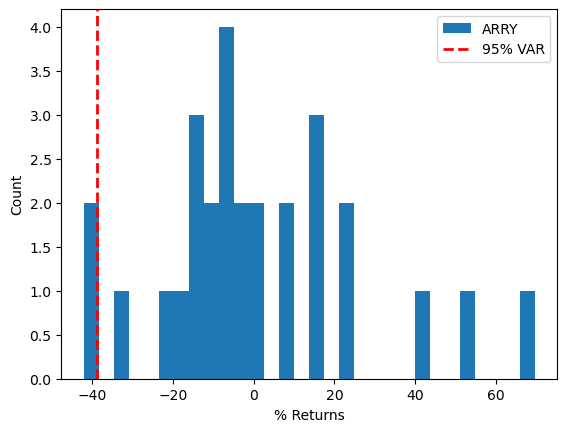

In [139]:
solver = True
if solver == True:
    new_stock = 'ARRY'         #Input The New Stock You Want to Solve
    risk_tol = 0.01           #Risk tolerance for every position we put on. Expressed as percentage (of the entire portfolio we can afford to lose)
    ns = pdr.get_data_yahoo(new_stock, start = risk_start, end = today)
    ns = ns.resample('M').last()
    ns = ns['Adj Close'].dropna().pct_change()
    ns95_ret = np.percentile(ns.dropna(), var_pct)
    max_risk = (len(hist_risk_ret.columns)+1)*(risk_tol)*port_val
    ns_pos = (max_risk - (-total_current_var_amt)) / -ns95_ret
    print('Max Acceptable Position', float("{:.2f}".format(ns_pos)), '$', f'|  New Stock {100-var_pct} % VAR', float("{:.2f}".format(ns95_ret))*100,'%')

    if plot == True:
        plt.hist(ns*100,bins=30,label = new_stock)
        plt.xlabel("% Returns")
        plt.ylabel("Count")
        plt.axvline(ns95_ret*100, color='r', linestyle = 'dashed', linewidth = 2, label= '95% VAR')
        plt.legend()
        plt.show()


In [140]:
# target_var_percent = -0.20
# new_stock = 'NEP'         #Input The New Stock You Want to Solve
# ns = pdr.get_data_yahoo(new_stock, start = risk_start, end = today)
# ns = ns.resample('M').last()
# ns = ns['Adj Close'].dropna().pct_change()
# ns95_ret = np.percentile(ns.dropna(), 5)
# ns_pos = (total_current_var_amt-(target_var_percent*sum(current_pos))) / (target_var_percent - (ns95_ret))
# print(ns_pos,ns95_ret)
